# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import numpy as np
import pandas as pd
import seaborn as sns

# import pandasql as ps
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numpy version :  1.26.4
pandas version :  2.1.4
seaborn version :  0.12.2


In [2]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Data Understanding

In [3]:
data = pd.read_csv('flight.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

In [4]:
# Change the format
data['LT'] = pd.to_datetime(data['LOAD_TIME'])
data['FFD'] = pd.to_datetime(data['FIRST_FLIGHT_DATE'])

mask = (data['LAST_FLIGHT_DATE'] != '2014/2/29 0:00:00')
data_filtered = data.loc[mask]
data_2 = data_filtered.copy()

data_2['LFD'] = pd.to_datetime(data_2['LAST_FLIGHT_DATE'], errors='coerce')

# Data Preprocessing

## Handling Missing Values

In [5]:
data_2.isna().sum()

MEMBER_NO               0
FFP_DATE                0
FIRST_FLIGHT_DATE       0
GENDER                  3
FFP_TIER                0
WORK_CITY            2269
WORK_PROVINCE        3248
WORK_COUNTRY           26
AGE                   420
LOAD_TIME               0
FLIGHT_COUNT            0
BP_SUM                  0
SUM_YR_1              551
SUM_YR_2              138
SEG_KM_SUM              0
LAST_FLIGHT_DATE        0
LAST_TO_END             0
AVG_INTERVAL            0
MAX_INTERVAL            0
EXCHANGE_COUNT          0
avg_discount            0
Points_Sum              0
Point_NotFlight         0
LT                      0
FFD                     0
LFD                   421
dtype: int64

In [6]:
data_null = data_2.isnull().sum().reset_index()
data_null.columns = ['feature','missing_value']
data_null['percentage'] = round((data_null['missing_value']/len(data_2))*100,2)
data_null = data_null.sort_values('percentage', ascending=False).reset_index(drop=True)
data_null = data_null[data_null['percentage']>0]
data_null

,feature,missing_value,percentage
0,WORK_PROVINCE,3248,5.16
1,WORK_CITY,2269,3.60
2,SUM_YR_1,551,0.87
3,LFD,421,0.67
4,AGE,420,0.67
5,SUM_YR_2,138,0.22
6,WORK_COUNTRY,26,0.04


Given that the percentage of missing values is below 10%, it is considered acceptable to remove them

In [7]:
data_2 = data_2.dropna()

## Duplicate Values

In [8]:
data_2.duplicated().sum()

0

In [9]:
data

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,LT,FFD
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,3/31/2014,1,3.483254,18,34,0.961639,619760,50,2014-03-31,2008-12-24
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,3/25/2014,7,5.194245,17,29,1.252314,415768,33,2014-03-31,2007-08-03
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,3/21/2014,11,5.298507,18,20,1.254676,406361,26,2014-03-31,2007-08-30
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,12/26/2013,97,27.863636,73,11,1.090870,372204,12,2014-03-31,2008-08-23
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,3/27/2014,5,4.788079,47,27,0.970658,338813,39,2014-03-31,2009-04-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62983,18375,5/20/2011,6/5/2013,Female,4,guangzhou,guangdong,CN,25.0,3/31/2014,...,6/9/2013,297,4.000000,4,1,0.000000,12318,22,2014-03-31,2013-06-05
62984,36041,3/8/2010,9/14/2013,Male,4,foshan,guangdong,CN,38.0,3/31/2014,...,1/3/2014,89,37.000000,60,14,0.000000,106972,43,2014-03-31,2013-09-14
62985,45690,3/30/2006,12/2/2006,Female,4,guangzhou,guangdong,CN,43.0,3/31/2014,...,3/3/2014,29,166.000000,166,0,0.000000,0,0,2014-03-31,2006-12-02
62986,61027,2/6/2013,2/14/2013,Female,4,guangzhou,guangdong,CN,36.0,3/31/2014,...,2/26/2013,400,12.000000,12,0,0.000000,0,0,2014-03-31,2013-02-14


In [10]:
data_2

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,LT,FFD,LFD
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,1,3.483254,18,34,0.961639,619760,50,2014-03-31,2008-12-24,2014-03-31
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,11,5.298507,18,20,1.254676,406361,26,2014-03-31,2007-08-30,2014-03-21
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,97,27.863636,73,11,1.090870,372204,12,2014-03-31,2008-08-23,2013-12-26
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,5,4.788079,47,27,0.970658,338813,39,2014-03-31,2009-04-15,2014-03-27
5,56972,2/10/2008,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,3/31/2014,...,79,7.043956,52,10,0.967692,343121,15,2014-03-31,2009-09-29,2014-01-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62982,16415,1/20/2013,1/20/2013,Female,4,beijing,.,CN,35.0,3/31/2014,...,437,0.000000,0,0,0.000000,0,0,2014-03-31,2013-01-20,2013-01-20
62983,18375,5/20/2011,6/5/2013,Female,4,guangzhou,guangdong,CN,25.0,3/31/2014,...,297,4.000000,4,1,0.000000,12318,22,2014-03-31,2013-06-05,2013-06-09
62984,36041,3/8/2010,9/14/2013,Male,4,foshan,guangdong,CN,38.0,3/31/2014,...,89,37.000000,60,14,0.000000,106972,43,2014-03-31,2013-09-14,2014-01-03
62985,45690,3/30/2006,12/2/2006,Female,4,guangzhou,guangdong,CN,43.0,3/31/2014,...,29,166.000000,166,0,0.000000,0,0,2014-03-31,2006-12-02,2014-03-03


In [11]:
# Group the data by types
categorical = data.select_dtypes(include=['object']).columns.tolist()
numericals = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

## Distribution 

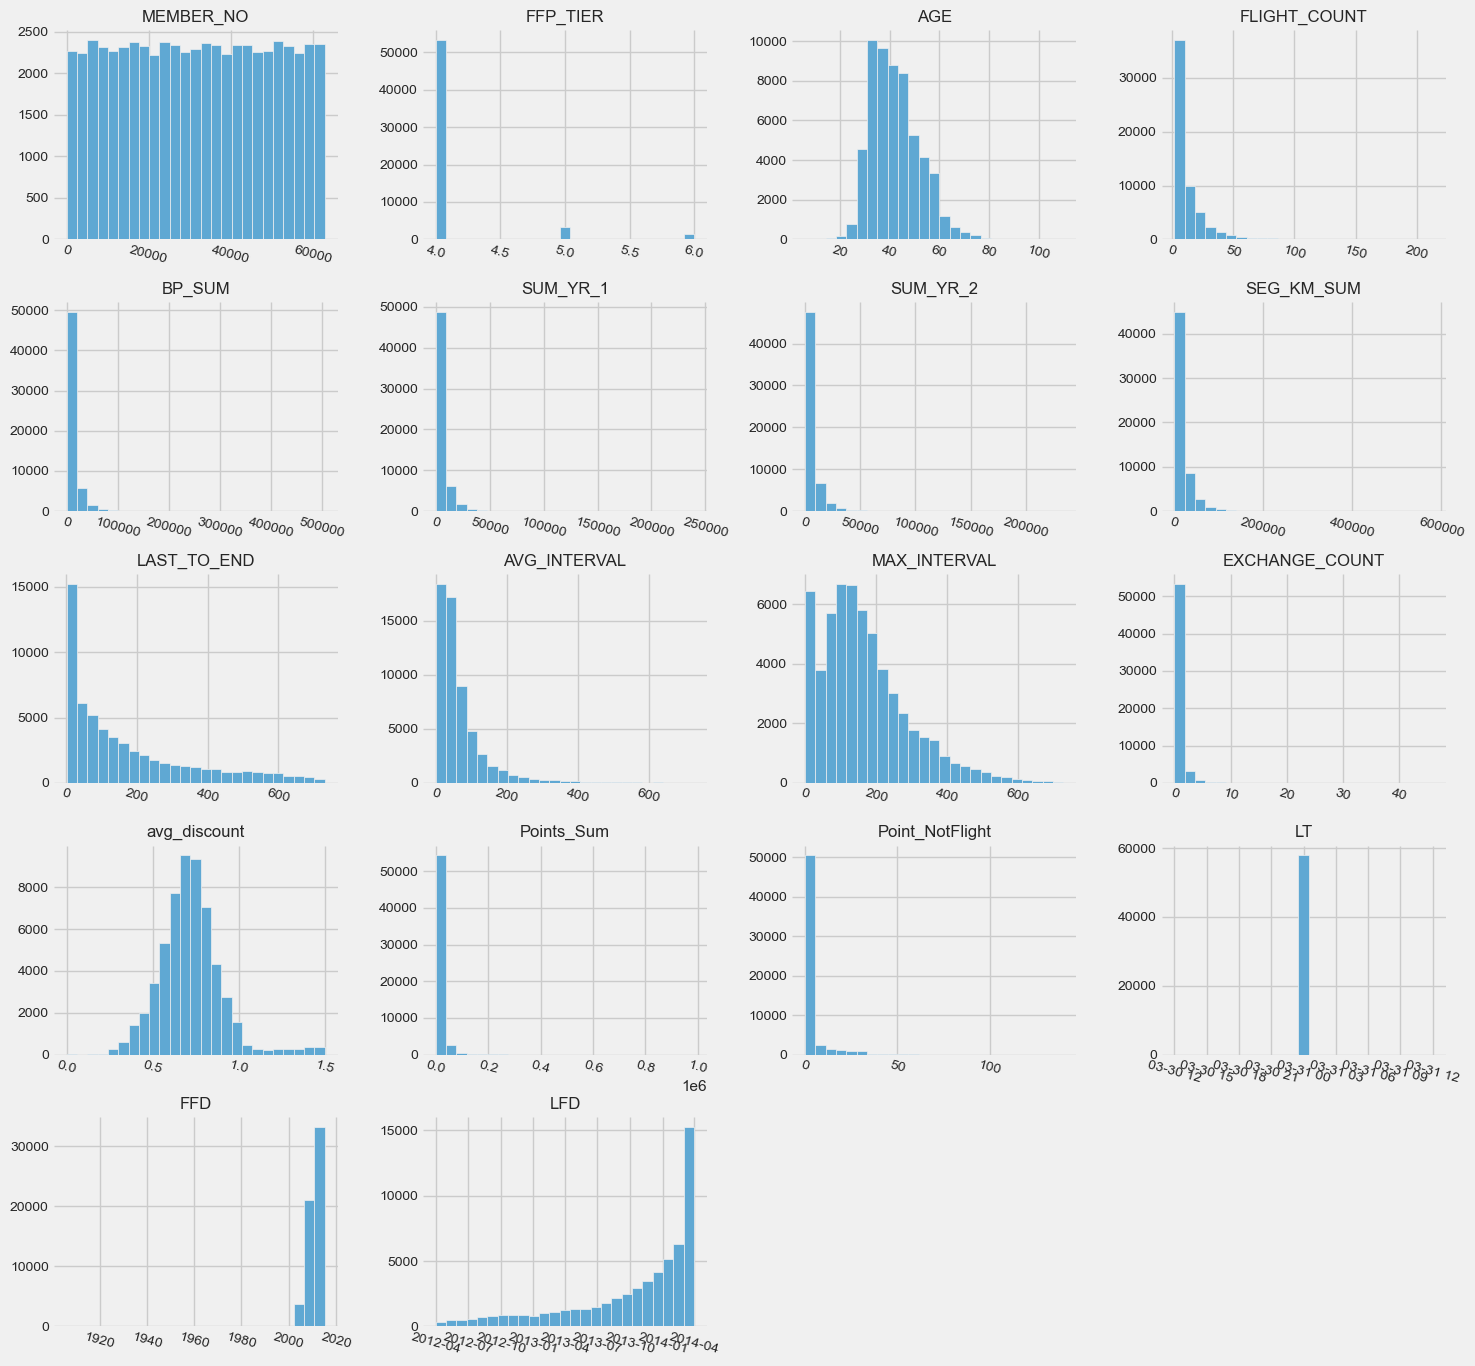

In [12]:
# Numeric Distribution
h = data_2.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15, color ='#5fa8d3')
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

The feature **avg_discount** and **age** follow a normal distribution, displaying a symmetrical bell-shaped curve when plotted on a graph. In contrast, the remaining features exhibit asymmetric distributions: some are negatively skewed like LFD and FFD features, while others are positively skewed excluding LT and FFP_Tier features

# Feature Engineering

In [13]:
# Determining LRFMC
data_2['Length'] = data_2['LT'] - data_2['FFD']
data_2['Length'] = data_2['Length'].dt.days

data_2['Recency'] = data_2['LT'] - data_2['LFD']
data_2['Recency'] = data_2['Recency'].dt.days

data_2['Frequency'] = data_2['FLIGHT_COUNT']
data_2['Monetary'] = data_2['SUM_YR_1'] + data_2['SUM_YR_2']
data_2['Monetary per Mile'] = data_2['SUM_YR_1'] + data_2['SUM_YR_2']/data_2['SEG_KM_SUM']
data_2['Customer Acquisition Value'] = data_2['avg_discount']

new_features = ['Length', 'Recency','Frequency', 'Monetary', 'Monetary per Mile', 'Customer Acquisition Value']
data_2[new_features].head()

,Length,Recency,Frequency,Monetary,Monetary per Mile,Customer Acquisition Value
0,1923,0,210,473748.0,239560.403274,0.961639
2,2405,10,135,328600.0,163618.581512,1.254676
3,2046,95,23,241850.0,116350.446086,1.090870
4,1811,4,152,255262.0,124560.421717,0.970658
5,1644,77,92,189310.0,112364.261201,0.967692


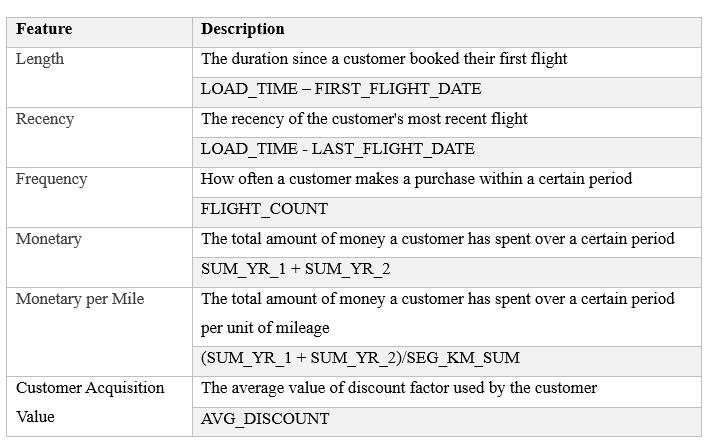

In [14]:
data_2[new_features].describe()

,Length,Recency,Frequency,Monetary,Monetary per Mile,Customer Acquisition Value
count,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000,57860.000000
mean,1283.726495,170.474888,12.043000,11043.096613,5364.127016,0.720626
std,856.994648,180.570850,14.239523,15350.753091,8110.416711,0.183942
min,-368.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,604.000000,27.000000,3.000000,2770.000000,1020.000000,0.612019
50%,1041.000000,103.000000,7.000000,5961.000000,2804.065356,0.711429
75%,1894.000000,257.250000,15.000000,13100.000000,6584.081573,0.808333
max,39537.000000,729.000000,213.000000,473748.000000,239560.403274,1.500000


There is data with negative numbers in the minimum length, which is abnormal. Moreover, the minimum Monetary value is zero, while the minimum frequency value is 2, which is not reasonable

In [15]:
# Filtering the DataFrame where 'Length' is less than or equal to 0
filtered_data = data_2[data_2['Length'] <= 0]

# Selecting specific columns to display along with the filtered results
display_columns = new_features + ['FIRST_FLIGHT_DATE', 'LOAD_TIME']
display(filtered_data[display_columns].head())

# Displaying the shape of the filtered DataFrame
display(filtered_data.shape)

,Length,Recency,Frequency,Monetary,Monetary per Mile,Customer Acquisition Value,FIRST_FLIGHT_DATE,LOAD_TIME
3293,-343,82,25,37942.0,18347.376226,0.807256,3/9/2015,3/31/2014
3733,-321,4,43,37145.0,14258.360658,0.625447,2/15/2015,3/31/2014
25240,-105,197,11,6396.0,576.312198,0.504935,7/14/2014,3/31/2014
28231,-368,7,8,7030.0,0.493506,0.570465,4/3/2015,3/31/2014
33198,-164,50,2,5767.0,1.263585,1.410000,9/11/2014,3/31/2014


(5, 32)

There are 5 negative numbers, we will exclude them

In [16]:
data_2.drop(filtered_data.index, inplace=True)

In [17]:
data_2[new_features].describe()

,Length,Recency,Frequency,Monetary,Monetary per Mile,Customer Acquisition Value
count,57855.000000,57855.000000,57855.000000,57855.000000,57855.000000,57855.000000
mean,1283.859926,170.483744,12.042503,11042.421398,5364.017031,0.720620
std,856.910912,180.574944,14.239383,15350.588584,8110.417531,0.183924
min,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,605.000000,27.000000,3.000000,2769.500000,1020.000000,0.612026
50%,1041.000000,103.000000,7.000000,5961.000000,2804.130713,0.711429
75%,1894.000000,258.000000,15.000000,13100.000000,6584.000000,0.808333
max,39537.000000,729.000000,213.000000,473748.000000,239560.403274,1.500000


In [18]:
# Filtering the DataFrame where 'Monetary' is equal to 0 and 'Frequency' is greater than or equal to 0
filtered_data_2 = data_2[(data_2['Monetary'] == 0) & (data_2['Frequency'] >= 0)]

# Selecting specific columns to display along with the filtered results
display_columns = new_features 
display(filtered_data_2[display_columns].head())

# Displaying the shape of the filtered DataFrame
display(filtered_data_2.shape)

,Length,Recency,Frequency,Monetary,Monetary per Mile,Customer Acquisition Value
4915,918,285,34,0.0,0.0,0.724819
12761,1064,182,25,0.0,0.0,0.543600
13382,1090,238,19,0.0,0.0,0.888564
18166,2381,127,13,0.0,0.0,0.765385
19037,1818,325,17,0.0,0.0,0.725812


(240, 32)

There are 240 customers with a monetary value of 0, which indicates there is a data entry error. In this project, we will drop it.

In [19]:
data_2.drop(filtered_data_2.index, inplace=True)

In [20]:
data_2[new_features].describe()

,Length,Recency,Frequency,Monetary,Monetary per Mile,Customer Acquisition Value
count,57615.000000,57615.000000,57615.000000,57615.000000,57615.000000,57615.000000
mean,1284.979606,170.217374,12.073627,11088.419509,5386.361283,0.720935
std,857.305414,180.823883,14.258800,15365.939991,8119.884745,0.183708
min,1.000000,0.000000,2.000000,162.000000,0.016482,0.136017
25%,606.000000,27.000000,3.000000,2800.000000,1024.460809,0.612423
50%,1042.000000,102.000000,7.000000,5995.000000,2827.044039,0.711606
75%,1896.000000,257.000000,15.000000,13140.000000,6610.125626,0.808499
max,39537.000000,729.000000,213.000000,473748.000000,239560.403274,1.500000


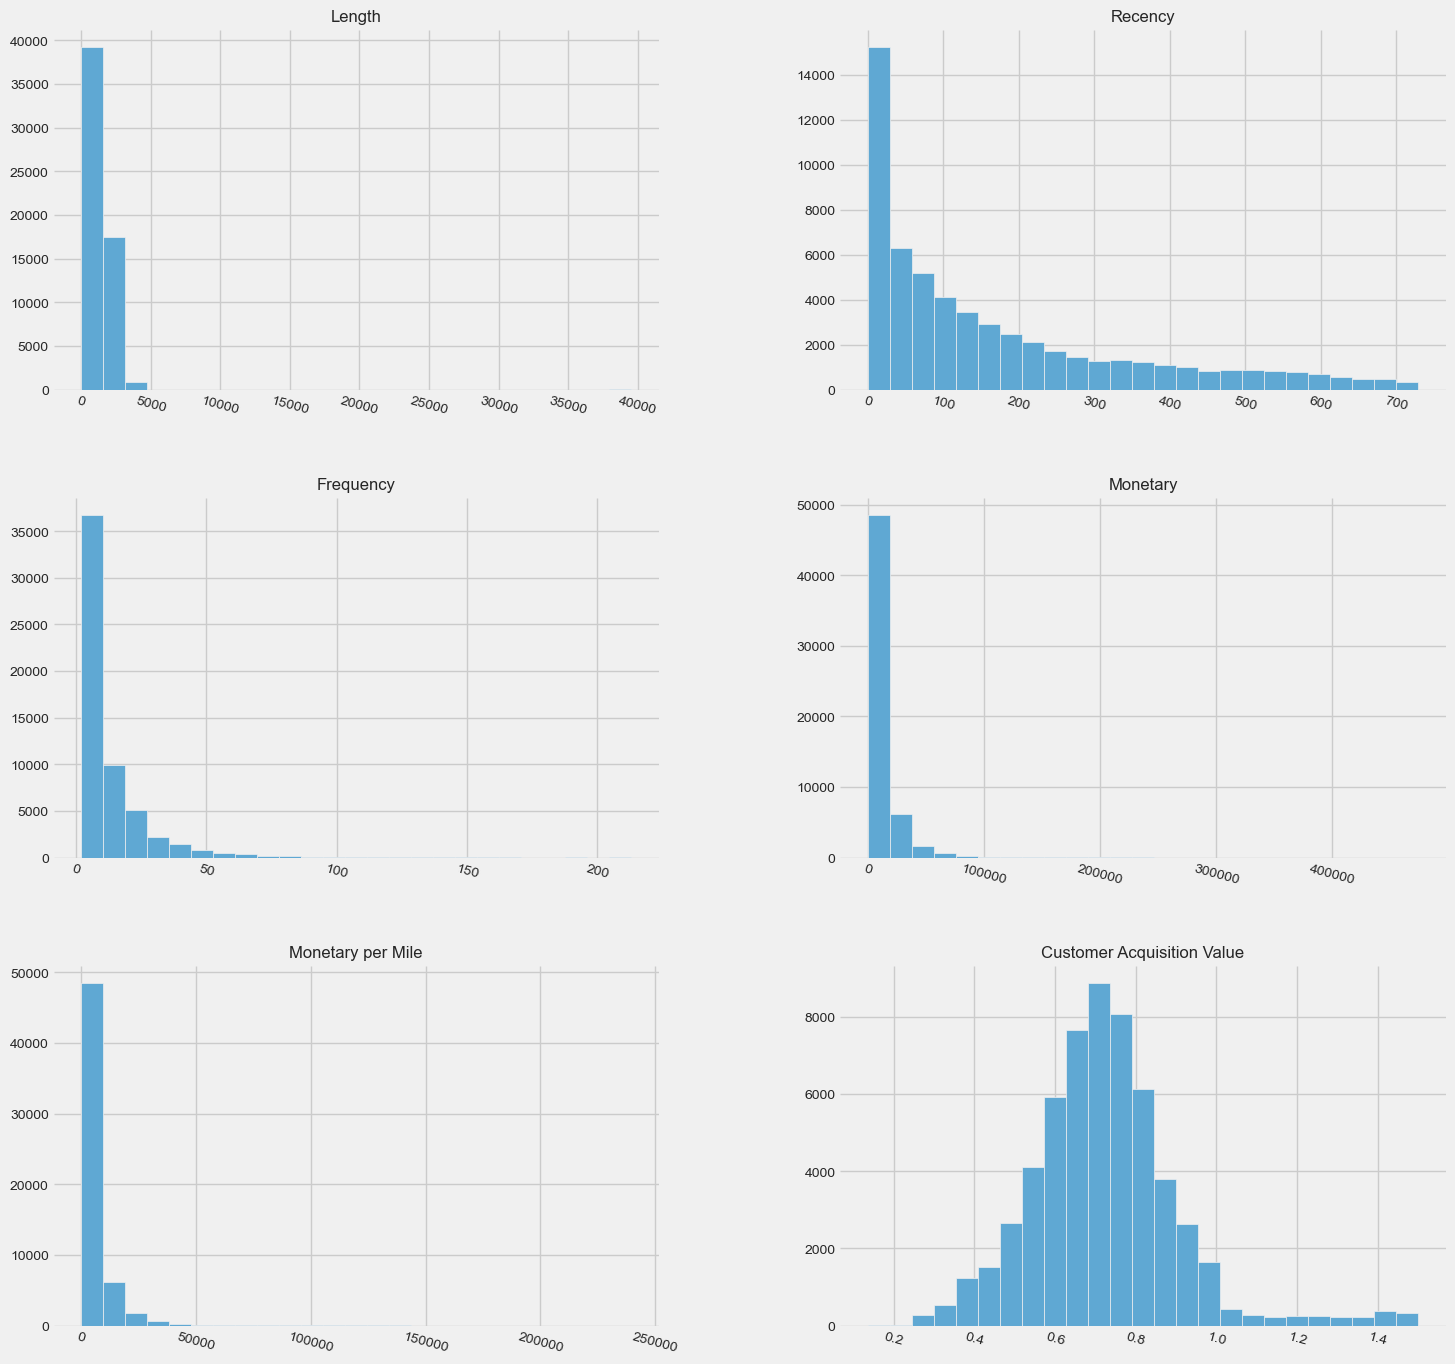

In [21]:
h = data_2[new_features].hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15, color ='#5fa8d3')
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

The feature **Customer Acquisition Value** follows a normal distribution. Meanwhile, the remaining features exhibit asymmetric distributions, which are positively skewed.

# Cluster Modelling

## Scalling Data

In [22]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_2[new_features].astype(float))

## Optimal N-Cluster

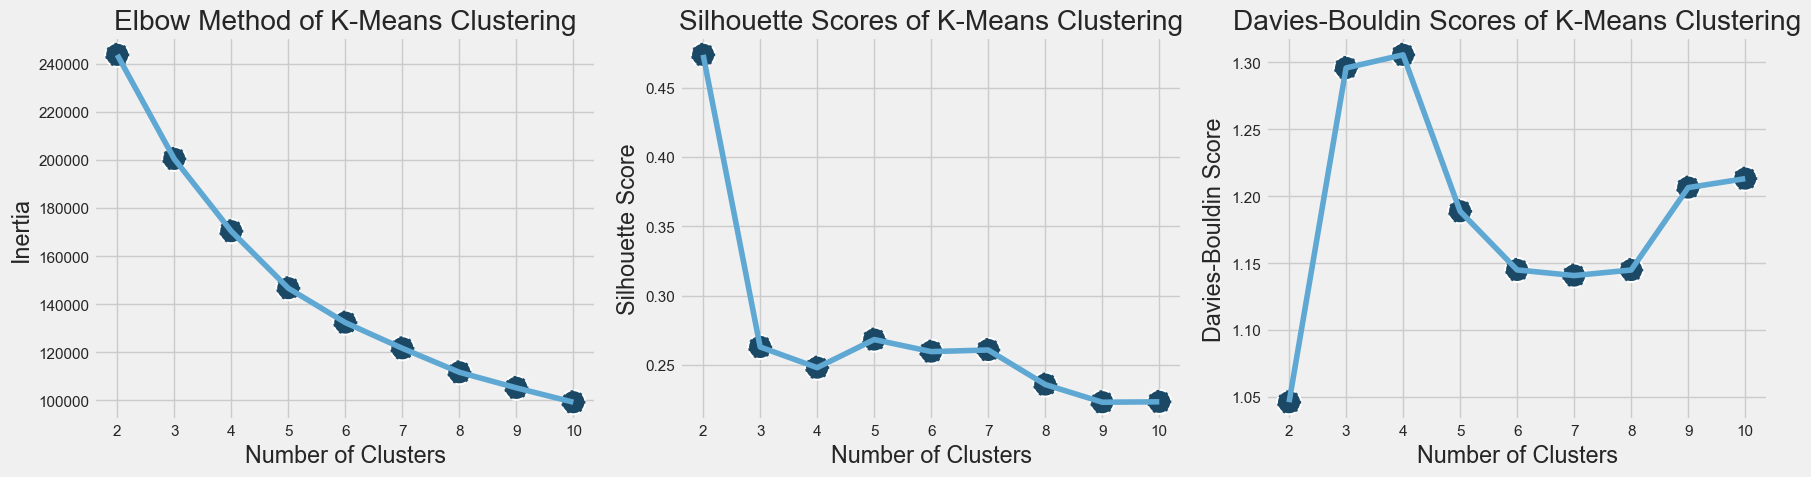

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

list_inertia = []
silhouette_scores = []
davies_bouldin_scores = []

range_n_clusters = range(2, 11)

# Evaluate each number of clusters
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Calculate inertia (for Elbow method)
    list_inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    silhouette_scores.append(silhouette_score(scaled_data, cluster_labels))
    
    # Calculate Davies-Bouldin score
    davies_bouldin_scores.append(davies_bouldin_score(scaled_data, cluster_labels))

# Plotting the results
plt.figure(figsize=(18, 5))

# Plot Elbow method 
plt.subplot(1, 3, 1)
sns.lineplot(x=range_n_clusters, y=list_inertia, color='#5fa8d3', linewidth=4)
sns.scatterplot(x=range_n_clusters, y=list_inertia, s=300, color='#1b4965', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method of K-Means Clustering')
plt.grid(True)

# Plot Silhouette scores
plt.subplot(1, 3, 2)
sns.lineplot(x=range_n_clusters, y=silhouette_scores, color='#5fa8d3', linewidth=4)
sns.scatterplot(x=range_n_clusters, y=silhouette_scores, s=300, color='#1b4965', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores of K-Means Clustering')
plt.grid(True)

# Plot Davies-Bouldin scores
plt.subplot(1, 3, 3)
sns.lineplot(x=range_n_clusters, y=davies_bouldin_scores, color='#5fa8d3', linewidth=4)
sns.scatterplot(x=range_n_clusters, y=davies_bouldin_scores, s=300, color='#1b4965', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Scores of K-Means Clustering')
plt.grid(True)

plt.tight_layout()
plt.show()

We can use 4 or 5 clusters.

In [36]:
data_3 = data_2[new_features]
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_3)
data_3['Clusters'] = kmeans.labels_

In [38]:
# Initialize the Rank list
Rank = []
for x in range(1, 4 + 1):
    Rank.append(f'Rank {x}')

# Get the value counts of clusters and reset the index
Data_cluster = data_3['Clusters'].value_counts().reset_index()

# Add the 'Cluster Rank' column to the DataFrame
Data_cluster['Cluster Rank'] = Rank

# Rename columns for clarity
Data_cluster.columns = ['Cluster', 'Count', 'Cluster Rank']

# Calculate the percentage of each cluster
total_count = Data_cluster['Count'].sum()
Data_cluster['Percentage'] = (Data_cluster['Count'] / total_count) * 100

Data_cluster


,Cluster,Count,Cluster Rank,Percentage
0,0,42486,Rank 1,73.741213
1,2,11867,Rank 2,20.597067
2,1,2870,Rank 3,4.981342
3,3,392,Rank 4,0.680378


In [39]:
perc = [0.1,0.2,0.3,00.4,0.5,0.6,0.7,0.8,0.9]
data_3.describe(percentiles=perc)

,Length,Recency,Frequency,Monetary,Monetary per Mile,Customer Acquisition Value,Clusters
count,57615.000000,57615.000000,57615.000000,57615.000000,57615.000000,57615.000000,57615.000000
mean,1284.979606,170.217374,12.073627,11088.419509,5386.361283,0.720935,0.482166
std,857.305414,180.823883,14.258800,15365.939991,8119.884745,0.183708,0.838128
min,1.000000,0.000000,2.000000,162.000000,0.016482,0.136017,0.000000
10%,409.000000,7.000000,2.000000,1548.000000,0.661926,0.510230,0.000000
20%,544.000000,19.000000,3.000000,2354.800000,700.000000,0.585498,0.000000
30%,674.000000,36.000000,4.000000,3292.000000,1328.022526,0.635460,0.000000
40%,841.000000,66.000000,5.000000,4462.600000,2012.009769,0.676018,0.000000
50%,1042.000000,102.000000,7.000000,5995.000000,2827.044039,0.711606,0.000000
60%,1314.000000,149.000000,9.000000,8086.400000,3935.095936,0.747952,0.000000


## Visualization

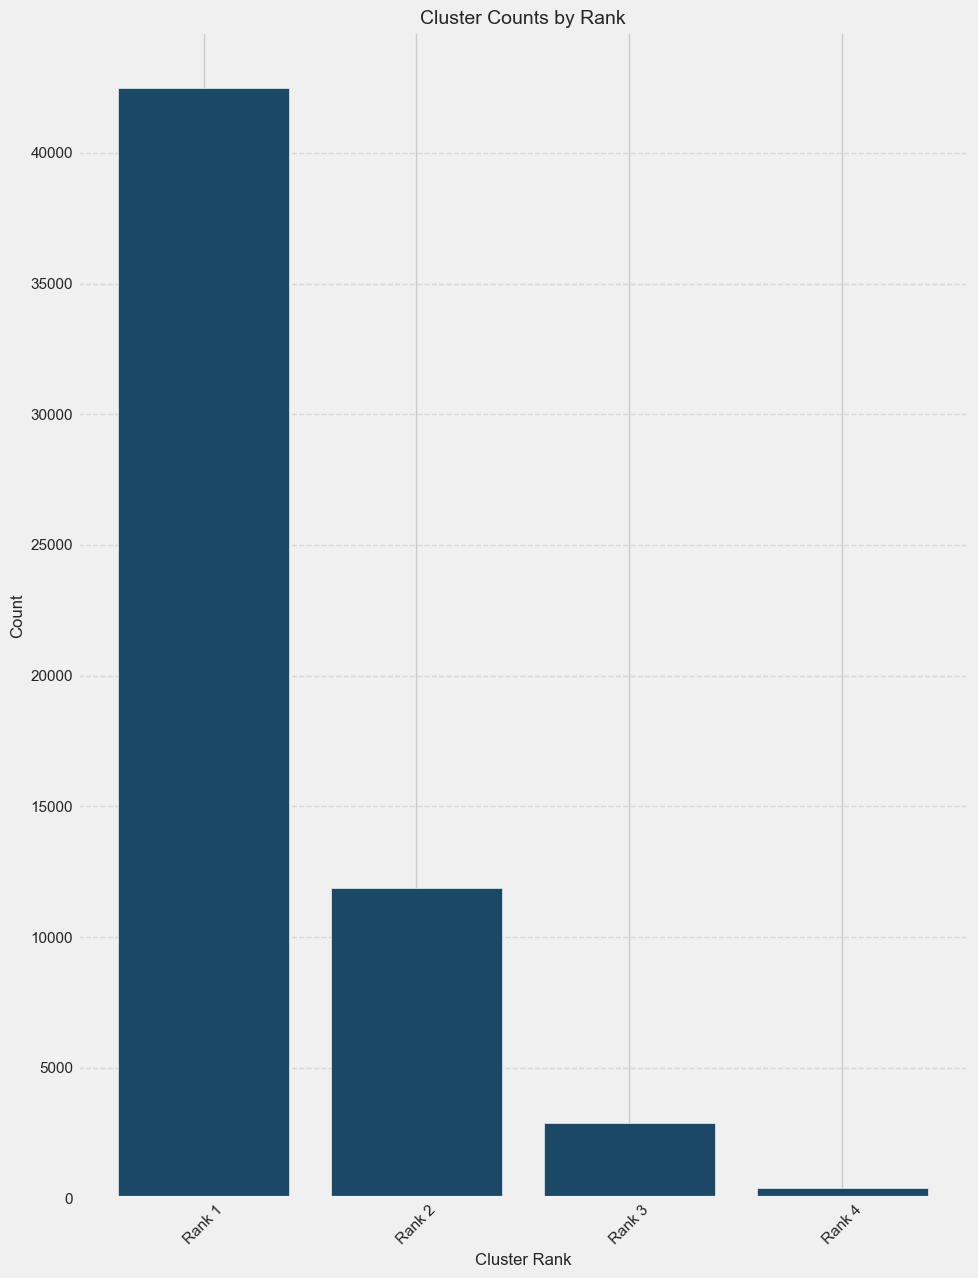

In [40]:
plt.figure(figsize=(10, 13))
plt.bar(Data_cluster['Cluster Rank'], Data_cluster['Count'], color='#1b4965')
plt.xlabel('Cluster Rank', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Cluster Counts by Rank', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

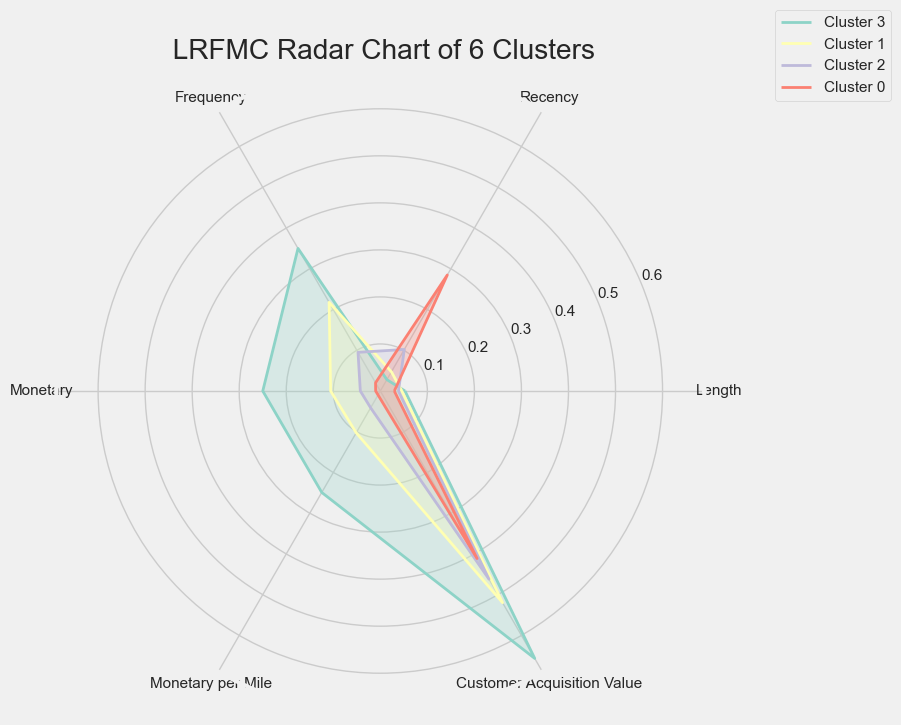

In [41]:
from math import pi

# Normalize the data for radar chart
lrfmc_clusters_normalized = data_3.copy()
lrfmc_clusters_normalized['Length'] = (data_3['Length'] - data_3['Length'].min()) / (data_3['Length'].max() - data_3['Length'].min())
lrfmc_clusters_normalized['Recency'] = (data_3['Recency'] - data_3['Recency'].min()) / (data_3['Recency'].max() - data_3['Recency'].min())
lrfmc_clusters_normalized['Frequency'] = (data_3['Frequency'] - data_3['Frequency'].min()) / (data_3['Frequency'].max() - data_3['Frequency'].min())
lrfmc_clusters_normalized['Monetary'] = (data_3['Monetary'] - data_3['Monetary'].min()) / (data_3['Monetary'].max() - data_3['Monetary'].min())
lrfmc_clusters_normalized['Monetary per Mile'] = (data_3['Monetary per Mile'] - data_3['Monetary per Mile'].min()) / (data_3['Monetary per Mile'].max() - data_3['Monetary per Mile'].min())
lrfmc_clusters_normalized['Customer Acquisition Value'] = (data_3['Customer Acquisition Value'] - data_3['Customer Acquisition Value'].min()) / (data_3['Customer Acquisition Value'].max() - data_3['Customer Acquisition Value'].min())


# Create a DataFrame for radar chart
categories = ['Length','Recency', 'Frequency', 'Monetary', 'Monetary per Mile', 'Customer Acquisition Value']
num_vars = len(categories)

palette = sns.color_palette("Set3", n_colors=len(data_3['Clusters'].unique()))


# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Create radar chart for each cluster
for i, cluster in enumerate(data_3['Clusters'].unique()):
    cluster_data = lrfmc_clusters_normalized[lrfmc_clusters_normalized['Clusters'] == cluster][categories].mean().values.flatten().tolist()

    # Close the loop
    values = cluster_data + cluster_data[:1]
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    ax.fill(angles, values, color=palette[i], alpha=0.25)
    ax.plot(angles, values, color=palette[i], linewidth=2, linestyle='solid', label=f'Cluster {cluster}')

# Add the labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Add title and legend
plt.title(' LRFMC Radar Chart of 6 Clusters')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.show()

## Interpretation

In [42]:
data_3.groupby('Clusters').agg({
                            'Length' : ['mean','median'],
                            'Recency' : ['mean','median'],
                            'Frequency' : ['mean','median'],
                            'Monetary' : ['mean','median'],
                            'Monetary per Mile' : ['mean','median'],
                            'Customer Acquisition Value' : ['mean','median']

})

Length             Recency         Frequency         \
                 mean  median        mean median       mean median   
Clusters                                                             
0         1174.933060   927.0  207.564515  148.0   6.281810    5.0   
1         1809.999652  1718.0   34.346690   12.0  47.950523   46.0   
2         1525.841577  1346.0   74.319710   33.0  22.025533   20.0   
3         2076.614796  2123.0   20.308673    8.0  75.862245   73.0   

               Monetary           Monetary per Mile                \
                   mean    median              mean        median   
Clusters                                                            
0           4879.059879    4062.0       2333.531237   1840.410644   
1          50201.614983   46957.0      24585.213247  23406.314575   
2          20310.474593   18841.0       9879.928480   9475.165334   
3         118531.926020  107368.5      59663.581354  54221.001774   

         Customer Acquisition Value            
                               mean    median  
Clusters                                       
0                          0.697089  0.693629  
1                          0.844864  0.779739  
2                          0.766079  0.738297  
3                          1.031456  0.962310

- The First group. acopunting for 73.74%. These customers have low data in all aspects and belong to low-value users except for recency. They can be characterized as inactive customers. They provide the least revenue for the company and have a shorter membership time. The data reveals significant gaps between their fligt booking, indicating extended periods of inactivity.
- The Second group, accounting for 4.98%, These customers may be referred to as consistent buyers. They shop regularly and provide stable financial contributions to the business. While their purchases may not be as substantial as those of customers in other clusters, they remain integral to the customer base.
- The Third group, accounting for 20.59%. These customers typically make occasional purchases, which may be due to seasonal reasons or related to promotional activities.. They do not shop frequently, and their financial contribution to the business is relatively modest. However, they continue to make purchases intermittently, albeit infrequently.
- The fourth group, accounting for 0.68%. Consists of loyal customers who have been members for a long time and are also elite customers who shop frequently and make significant financial contributions to the business. From the data, it is evident that they often shop within short periods, and their purchases tend to be of high value